In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
from scipy import integrate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



(500, 2)
(500, 2)


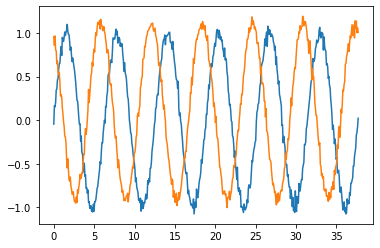

torch.Size([499, 2])
torch.Size([499, 2])


In [131]:
#make the data 
t = np.linspace(0, 12*np.pi, 500)
x = np.array([np.sin(t), np.cos(t+0.5) + 0.1]).T  
x = x + np.random.normal(0,0.05, x.shape) #add noise
print(x.shape)

plt.plot(t ,x[:,0]) #plot so we can see what it looks like
plt.plot(t, x[:,1])

plt.show()

#make data into inputs and outputs and put into torch tensors (which are a lot like np arrasys, but the way pytorch likes them)
# inputs = x[:499]
# outputs = x[1:]
# inputs = torch.from_numpy(inputs).float()
# outputs = torch.from_numpy(outputs).float()
# print(inputs.shape)
# print(outputs.shape)

# np.save("inputs_with_noise.npy", inputs)
# np.save("outputs_with_noise.npy", outputs)
inputs = np.load("inputs.npy")
inputs = np.load("outputs.npy")
t = np.linspace(0, 12*np.pi, 500)
x_test = np.array([np.sin(t), np.cos(t+0.5) + 0.1]).T 
x_test = x_test + np.random.normal(0,0.05, x.shape)
inputs_test = torch.from_numpy(x_test[:499]).float()
outputs_test = torch.from_numpy(x_test[1:]).float()

In [216]:
#2 cosine problem 
omega1 = 1
omega2 = 8
# system
mu = -0.05
lam = -1.0
# adjustable parameters
dt = 0.01*8       # set to 5e-4 for Lorenz
noise = 0.1     # for study of noisy measurements, we use noise=0.01, 0.02; otherwise we leave it as 0.
n_forward = 5
total_steps = 100 * n_forward
t = np.linspace(0, (total_steps)*dt, total_steps+1)
# total_steps = 5000

# system
noise = 0.2     # for study of noisy measurements, we use noise=0.01, 0.02; otherwise we leave it as 0.

mu = 2.0
def van_der_pol_rhs(x):
    return np.array([x[1], mu*(1-x[0]**2)*x[1]-x[0]])

# simulation parameters
np.random.seed(2)
n = 2

# dataset 
n_train = 1

# simulate training trials 
train_data = np.zeros((n_train, total_steps+1, n))
print('generating training trials ...')
for i in tqdm(range(n_train)):
    x_init = [np.random.uniform(-2.0, 2.0), np.random.uniform(-4.0, 4.0)]
    sol = sp.integrate.solve_ivp(lambda _, x: van_der_pol_rhs(x), [0, total_steps*dt], x_init, t_eval=t)
    train_data[i, :, :] = sol.y.T
    
    
print(train_data.shape)

inputs = train_data[0,:-1]
outputs = train_data[0,1:]
print(inputs.shape)
print(outputs.shape)

# inputs = torch.from_numpy(inputs).float()
# outputs = torch.from_numpy(outputs).float()

# inputs_test = inputs
# outputs_test = outputs



generating training trials ...


  0%|          | 0/1 [00:00<?, ?it/s]

(1, 501, 2)
(500, 2)
(500, 2)


In [217]:
np.save("inputs_harder.npy", inputs)
np.save("outputs_harder.npy", outputs)

In [212]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = torch.nn.Linear(2, 100)
        self.layer2 = torch.nn.Linear(100, 100)
        self.layer3 = torch.nn.Linear(100, 2)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x) #1 -> 10 in the middle
        x = self.relu(x) #doing the activation on the hidden layer
        x = self.layer2(x) # 10 -> 10
        x = self.relu(x) #doing the activation on the hidden layer
        x = self.layer2(x) # 10 -> 10
        x = self.relu(x) #doing the activation on the hidden layer
        x = self.layer2(x) # 10 -> 10
        x = self.relu(x) #doing the activation on the hidden layer
        x = self.layer3(x) # 10 -> 1
        
        return x

net = Net()
print(net)

Net(
  (layer1): Linear(in_features=2, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=2, bias=True)
  (relu): ReLU()
)


In [213]:
# Define Optimizer and Loss Function
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

epoch =  0 : error =  2.2644756
epoch =  100 : error =  0.11778354
epoch =  200 : error =  0.047478706
epoch =  300 : error =  0.021125339
epoch =  400 : error =  0.009256952
epoch =  500 : error =  0.0069150217
epoch =  600 : error =  0.007216228
epoch =  700 : error =  0.0031846205
epoch =  800 : error =  0.0023712378
epoch =  900 : error =  0.0013145348
epoch =  1000 : error =  0.003971611
epoch =  1100 : error =  0.0018162385
epoch =  1200 : error =  0.0019037098
epoch =  1300 : error =  0.002076783
epoch =  1400 : error =  0.000876899
epoch =  1500 : error =  0.0011838425
epoch =  1600 : error =  0.0012888722
epoch =  1700 : error =  0.0011877668
epoch =  1800 : error =  0.00082167663
epoch =  1900 : error =  0.00068516505
epoch =  2000 : error =  0.0009424799
epoch =  2100 : error =  0.00068326085
epoch =  2200 : error =  0.00092594814
epoch =  2300 : error =  0.00056555896
epoch =  2400 : error =  0.0004645018


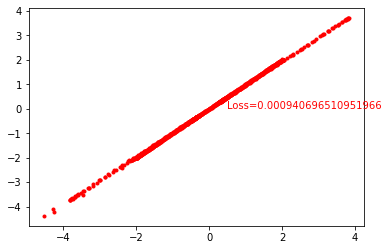

In [214]:
error_list = list()
for i in range(2500):
    prediction = net(inputs)
    loss = loss_func(prediction, outputs) 
    
    if i %10 == 0:
        error_list.append(loss.detach().numpy())
    optimizer.zero_grad()
    loss.backward()        
    optimizer.step()       

    if i % 100 == 0:
        print("epoch = ", i, ": error = ", loss.detach().numpy())
#     if i % 100 == 0:
#         # plot and show learning process
#         plt.cla()
#         plt.scatter(x.data.numpy(), y.data.numpy())
#         plt.plot(x.data.numpy(), prediction.data.numpy(), 'r.', lw=2)
#         plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
#         plt.pause(0.1)

plt.show()

# plot and show learning process
plt.cla()
# plt.scatter(inputs.data.numpy(), outputs.data.numpy())
plt.plot(outputs.data.numpy(), prediction.data.numpy(), 'r.', lw=2)
plt.text(0.5, 0, 'Loss={}'.format(loss.data.numpy()), fontdict={'size': 10, 'color':  'red'})
plt.pause(0.1)

predicted shape =  (499, 2)
inputs_test shape =  torch.Size([500, 2])
error =  4.153619299632764


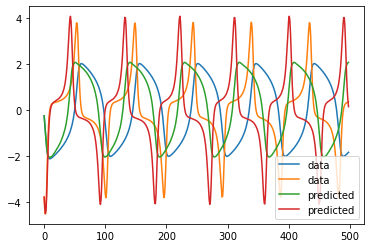

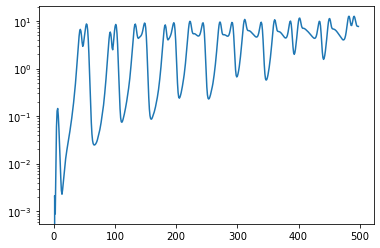

In [215]:
timesteps = 499

predicted = np.zeros((timesteps, 2))

y_pred = inputs_test[0]
predicted[0] = y_pred
for i in range(timesteps-1):
    y_pred = net(y_pred)
    predicted[i + 1] = y_pred.detach().numpy()
    
# print(predicted)

plt.plot(inputs_test[:timesteps], label = "data")
plt.plot(predicted, label = "predicted")
plt.legend()

print("predicted shape = ", predicted.shape)
print("inputs_test shape = ", inputs_test.shape)
print("error = ", np.mean((inputs_test[:timesteps].detach().numpy() - predicted[:,:timesteps])**2))
plt.show()
plt.semilogy(np.mean((inputs_test[:timesteps].detach().numpy() - predicted)**2 ,axis = 1))

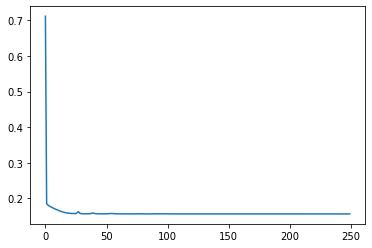

In [7]:
plt.plot(error_list)